In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [3]:
road = 7
direction = "in"
df = pd.read_csv(
    f"../dataset/cluster/2020-02-road{road}-{direction}-5cluster.csv", parse_dates=["datetime"])
df['label'] = df['cluster'].apply(lambda row: 1 if row == 0 or row == 1 else 0)
df


,datetime,road_number,km,direction,all_units,inflow_units,outflow_unit,samecell_units,avg_speed,max_speed,avg_traveltime,max_traveltime,inflow_units_N,outflow_units_N,avg_speed_N,cluster,label
0,2020-02-01 00:00:34,7,2,in,3,3,0,0,59,81,60,61,0.057692,0.000000,0.7375,2,0
1,2020-02-01 00:00:34,7,3,in,0,0,5,0,0,0,0,0,0.000000,0.113636,0.0000,1,1
2,2020-02-01 00:00:34,7,6,in,1,0,3,1,5,5,0,0,0.000000,0.068182,0.0625,1,1
3,2020-02-01 00:00:34,7,7,in,1,1,4,0,72,72,20,20,0.019231,0.090909,0.9000,3,0
4,2020-02-01 00:00:34,7,10,in,10,7,6,3,69,103,43,60,0.134615,0.136364,0.8625,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4503722,2020-02-29 23:59:14,7,108,in,2,2,2,0,38,52,68,76,0.038462,0.045455,0.4750,0,1
4503723,2020-02-29 23:59:14,7,109,in,1,1,3,0,36,36,60,60,0.019231,0.068182,0.4500,0,1
4503724,2020-02-29 23:59:14,7,111,in,1,1,0,0,64,64,60,60,0.019231,0.000000,0.8000,2,0
4503725,2020-02-29 23:59:14,7,114,in,0,0,1,0,0,0,0,0,0.000000,0.022727,0.0000,1,1


In [4]:
df[df['label']==1].max(axis=0)

datetime           2020-02-29 23:59:14
road_number                          7
km                                 124
direction                           in
all_units                           71
inflow_units                        33
outflow_unit                        33
samecell_units                      49
avg_speed                           49
max_speed                          150
avg_traveltime                     926
max_traveltime                     997
inflow_units_N                0.634615
outflow_units_N                   0.75
avg_speed_N                     0.6125
cluster                              1
label                                1
dtype: object

In [5]:
df_corr = df.filter(['all_units','inflow_units','outflow_unit','samecell_units','avg_speed','max_speed','avg_traveltime','max_traveltime','label'],axis=1)
corr = df_corr.corr()

<AxesSubplot:>

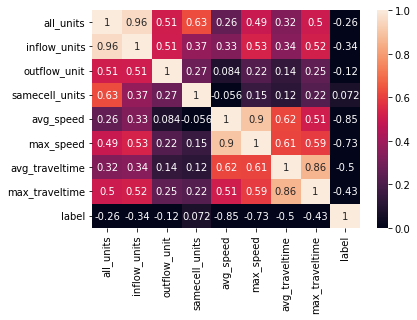

In [6]:
sns.heatmap(corr, vmin=0, vmax=1, annot=True)


In [7]:
num_cols = ['all_units', 'inflow_units',
            'avg_speed', 'max_speed',
            'avg_traveltime',"max_traveltime"]
num_cols

['all_units',
 'inflow_units',
 'avg_speed',
 'max_speed',
 'avg_traveltime',
 'max_traveltime']

In [8]:
X=df[num_cols]
y=df['label']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
param_grid = {"max_depth": np.arange(1, 10),
              "criterion": ["entropy", "gini"]}
tree = GridSearchCV(DecisionTreeClassifier(), param_grid)
tree.fit(x_train, y_train)
tree.best_estimator_


DecisionTreeClassifier(criterion='entropy', max_depth=9)

In [ ]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(x_train, y_train)

In [11]:
y_pred = tree.predict(x_test)

In [12]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1170725
           1       0.99      0.99      0.99    315505

    accuracy                           0.99   1486230
   macro avg       0.99      0.99      0.99   1486230
weighted avg       0.99      0.99      0.99   1486230



In [14]:
from sklearn.metrics import accuracy_score,f1_score

In [15]:
print(accuracy_score(y_test, y_pred))
# print(f1_score(y_test, y_pred))

0.9947114511212934


In [ ]:
import joblib

In [ ]:
joblib.dump(tree, f"DecisionTreeModelRoad{road}{direction}.joblib")


In [ ]:
model_test = joblib.load(f'DecisionTreeModelRoad{road}{direction}.joblib')


In [ ]:
df_km127 = pd.read_csv("../dataset/latlon_km127.csv")

In [ ]:
def map_traffic_with_latlon(df):
    df['lat'] = df.apply(lambda row: df_km127[(df_km127['rd'] == row['road_number']) & (df_km127['km'] == row['km'])]['lat'].values[0]
                         if len(df_km127[(df_km127['rd'] == row['road_number']) & (df_km127['km'] == row['km'])]['lat'].values) > 0 else 0, axis=1)
    df['lon'] = df.apply(lambda row: df_km127[(df_km127['rd'] == row['road_number']) & (df_km127['km'] == row['km'])]['lon'].values[0]
                         if len(df_km127[(df_km127['rd'] == row['road_number']) & (df_km127['km'] == row['km'])]['lon'].values) > 0 else 0, axis=1)
    return df


In [ ]:
header_list = ['datetime', 'road_number', 'km', 'direction', 'all_units', 'inflow_units',
               'outflow_unit', 'samecell_units', 'avg_speed', 'max_speed', 'avg_traveltime', 'max_traveltime']
df_current = pd.read_csv("../dataset/current_celldata.csv",
                         names=header_list, parse_dates=["datetime"])
df_current = df_current[(df_current['road_number'] == 1) | (
    df_current['road_number'] == 2) | (df_current['road_number'] == 7)]
df_current = map_traffic_with_latlon(df_current)
df_current


In [ ]:
x_predict = df_current[num_cols]
x_predict

In [ ]:
y_predict = model_test.predict(x_predict)
y_predict


In [ ]:
df_current["cluster"] = y_predict
df_current

In [ ]:
df_current[df_current["cluster"] == 3].min(axis=0)
